In [1]:
from __future__ import division, print_function, absolute_import

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=False)

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist as mn
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from keras import backend as K
K.set_image_dim_ordering('th')

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Using TensorFlow backend.


In [2]:
# Training Parameters
learning_rate = 0.01
num_steps = 500
batch_size = 128
n_images = 10000

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.25 # Dropout, probability to drop a unit

In [3]:
# Create the neural network
def conv_net(x_dict, n_classes, dropout, reuse, is_training):
    
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict['images']

        # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, 28, 28, 1])

        # Convolution Layer with 32 filters 
        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)

        # Convolution Layer with 64 filters 
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # Fully connected layer (in tf contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)

    return out


In [4]:
# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):
    
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    logits_train = conv_net(features, num_classes, dropout, reuse=False, is_training=True)
    logits_test = conv_net(features, num_classes, dropout, reuse=True, is_training=False)
    
    # Predictions
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
        
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs

In [5]:
# Build the Estimator
model = tf.estimator.Estimator(model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmphza2jmo2', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c3d673358>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [6]:
# Define the input function for training
X_tr={'images': mnist.train.images}
Y_tr=mnist.train.labels
input_fn = tf.estimator.inputs.numpy_input_fn(
    x=X_tr, y=Y_tr,
    batch_size=batch_size, num_epochs=None, shuffle=True)
# Train the Model
model.train(input_fn, steps=num_steps)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmphza2jmo2/model.ckpt.
INFO:tensorflow:loss = 2.3210342, step = 1
INFO:tensorflow:global_step/sec: 1.6965
INFO:tensorflow:loss = 0.1510069, step = 101 (58.946 sec)
INFO:tensorflow:global_step/sec: 1.55447
INFO:tensorflow:loss = 0.04007265, step = 201 (64.337 sec)
INFO:tensorflow:global_step/sec: 1.63674
INFO:tensorflow:loss = 0.2052337, step = 301 (61.090 sec)
INFO:tensorflow:global_step/sec: 1.56438
INFO:tensorflow:loss = 0.11538661, step = 401 (63.924 sec)
INFO:tensorflow:Saving checkpoints for 500 into /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmphza2jmo2/model.ckpt.
INFO:tensorflow:Loss for final step: 0.086896375.


In [7]:
# Evaluate the Model
# Define the input function for evaluating
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.test.images}, y=mnist.test.labels,
    batch_size=batch_size, shuffle=False)
# Use the Estimator 'evaluate' method
model.evaluate(input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-10-17-04:06:18
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmphza2jmo2/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-17-04:06:30
INFO:tensorflow:Saving dict for global step 500: accuracy = 0.9593, global_step = 500, loss = 0.15172128
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 500: /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmphza2jmo2/model.ckpt-500


{'accuracy': 0.9593, 'loss': 0.15172128, 'global_step': 500}

In [9]:
write = 1
if write==1:
    f = open("sheer.txt", 'w')

# Predict single images
# Get images from test set
test_images = mnist.test.images[:n_images]
test_label=mnist.test.labels[:n_images]

# # reshape to be [samples][pixels][width][height]
X_test = test_images
y_test = test_label
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
# # convert from int to float
X_test = X_test.astype('float32')

X_test_backup = X_test
Y_test_backup = y_test

yBackup = []
pBackup = []
sheer = 0.0

for s in range(0,100):
    X_test = X_test_backup
    y_test = Y_test_backup
    
    datagen = ImageDataGenerator(shear_range=sheer)# fit parameters from data
    datagen.fit(X_test)
    tmp = []
    # configure batch size and retrieve one batch of images
    for X_batch, y_batch in datagen.flow(X_test, y_test, batch_size=n_images):
        tmp = X_batch
        yTemp = y_batch
        break
    X_test = tmp
    y_test = yTemp

    x_te={'images': tmp}
    input_fn = tf.estimator.inputs.numpy_input_fn(
        x=x_te, shuffle=False)
    # Use the model to predict the images class
    preds = list(model.predict(input_fn))
    accuracy = 0.0
    # Display
    for i in range(n_images):
        if (preds[i] == y_test[i]):
                accuracy = accuracy + 1/n_images
#         plt.imshow(np.reshape(tmp[i], [28, 28]), cmap='gray')
#         plt.show()
#         print("Model prediction:", preds[i])
    print("Model accuracy:", accuracy)
    yBackup.append(y_test)
    pBackup.append(preds)
    if write==1:
        f.write(str(sheer)+"\t"+str(accuracy)+"\n")
    
    sheer = sheer+0.5
if write==1:    
    f.close()
print("Done!")

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmphza2jmo2/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.9592999999999107
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmphza2jmo2/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.9588999999999107
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmphza2jmo2/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_o

INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.9539999999999113
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmphza2jmo2/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.9512999999999115
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmphza2jmo2/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.9526999999999114
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmphza2jmo2/model.ckpt-500
I

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.9312999999999138
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmphza2jmo2/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.9298999999999139
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmphza2jmo2/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.9268999999999142
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.865699999999921
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmphza2jmo2/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.8678999999999207
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmphza2jmo2/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.8639999999999212
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6j

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.7816999999999302
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmphza2jmo2/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.7693999999999316
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmphza2jmo2/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.7800999999999304
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6

In [10]:
print(len(pBackup[0]))

10000


In [12]:
yTotal = [0]*10

for y in y_test:
    yTotal[y] = yTotal[y]+1

aMatrix = []
for i in range(len(pBackup)):
    print("\n\nYmatrix for rotation %d"%(i))
    yMatrix = [[0]*10 for i in range(10)]
    for j in range(len(pBackup[i])):
        yMatrix[yBackup[i][j]][pBackup[i][j]] += 1

    sum = 0
    
    for x in range(len(yMatrix)):
        for y in range(len(yMatrix[x])):
            yMatrix[x][y] = round(yMatrix[x][y]/yTotal[x], 3)

    aMatrix.append(yMatrix)
    for x in yMatrix:
        for y in x:
            print("%f" % (y),end=" ")
        print()
    



Ymatrix for rotation 0
0.989000 0.001000 0.002000 0.000000 0.000000 0.000000 0.005000 0.000000 0.002000 0.001000 
0.000000 0.993000 0.004000 0.000000 0.001000 0.000000 0.000000 0.001000 0.001000 0.000000 
0.009000 0.006000 0.973000 0.000000 0.001000 0.000000 0.004000 0.003000 0.003000 0.002000 
0.003000 0.000000 0.015000 0.956000 0.000000 0.005000 0.002000 0.002000 0.008000 0.009000 
0.003000 0.001000 0.008000 0.000000 0.936000 0.000000 0.017000 0.004000 0.003000 0.027000 
0.007000 0.002000 0.000000 0.008000 0.000000 0.951000 0.016000 0.000000 0.009000 0.008000 
0.010000 0.006000 0.002000 0.000000 0.000000 0.005000 0.975000 0.000000 0.001000 0.000000 
0.001000 0.001000 0.025000 0.000000 0.000000 0.000000 0.000000 0.940000 0.007000 0.026000 
0.018000 0.000000 0.030000 0.003000 0.003000 0.004000 0.008000 0.002000 0.917000 0.014000 
0.011000 0.004000 0.002000 0.006000 0.002000 0.002000 0.000000 0.013000 0.002000 0.958000 


Ymatrix for rotation 1
0.989000 0.001000 0.002000 0.000000 0.00

0.009000 0.002000 0.000000 0.009000 0.000000 0.938000 0.018000 0.000000 0.011000 0.012000 
0.015000 0.006000 0.002000 0.000000 0.000000 0.003000 0.973000 0.000000 0.001000 0.000000 
0.001000 0.002000 0.025000 0.000000 0.000000 0.001000 0.000000 0.938000 0.007000 0.026000 
0.023000 0.001000 0.033000 0.003000 0.004000 0.004000 0.008000 0.003000 0.905000 0.016000 
0.011000 0.004000 0.002000 0.006000 0.003000 0.002000 0.000000 0.012000 0.005000 0.955000 


Ymatrix for rotation 15
0.987000 0.001000 0.003000 0.000000 0.000000 0.000000 0.007000 0.000000 0.001000 0.001000 
0.000000 0.991000 0.004000 0.000000 0.001000 0.000000 0.001000 0.003000 0.001000 0.000000 
0.009000 0.008000 0.967000 0.000000 0.002000 0.000000 0.005000 0.004000 0.005000 0.001000 
0.006000 0.000000 0.017000 0.950000 0.000000 0.005000 0.003000 0.002000 0.007000 0.011000 
0.003000 0.001000 0.007000 0.000000 0.937000 0.000000 0.019000 0.004000 0.004000 0.024000 
0.008000 0.003000 0.000000 0.010000 0.000000 0.937000 0.015000 0

0.002000 0.002000 0.028000 0.000000 0.001000 0.002000 0.000000 0.937000 0.007000 0.021000 
0.026000 0.001000 0.031000 0.003000 0.002000 0.006000 0.010000 0.003000 0.899000 0.018000 
0.012000 0.005000 0.004000 0.005000 0.001000 0.003000 0.001000 0.013000 0.001000 0.955000 


Ymatrix for rotation 29
0.985000 0.001000 0.003000 0.000000 0.000000 0.000000 0.008000 0.000000 0.001000 0.002000 
0.001000 0.991000 0.004000 0.001000 0.000000 0.000000 0.000000 0.003000 0.001000 0.000000 
0.011000 0.007000 0.960000 0.001000 0.002000 0.000000 0.004000 0.011000 0.003000 0.002000 
0.002000 0.000000 0.013000 0.956000 0.000000 0.004000 0.003000 0.002000 0.011000 0.009000 
0.002000 0.006000 0.013000 0.000000 0.915000 0.000000 0.019000 0.005000 0.008000 0.031000 
0.009000 0.004000 0.000000 0.012000 0.000000 0.935000 0.018000 0.000000 0.016000 0.006000 
0.021000 0.007000 0.003000 0.000000 0.000000 0.007000 0.961000 0.000000 0.000000 0.000000 
0.002000 0.003000 0.028000 0.001000 0.000000 0.001000 0.001000 0

0.003000 0.004000 0.032000 0.001000 0.002000 0.001000 0.000000 0.921000 0.008000 0.028000 
0.031000 0.005000 0.035000 0.004000 0.005000 0.006000 0.010000 0.001000 0.884000 0.018000 
0.015000 0.006000 0.006000 0.005000 0.003000 0.005000 0.001000 0.014000 0.007000 0.939000 


Ymatrix for rotation 38
0.986000 0.001000 0.002000 0.000000 0.001000 0.001000 0.006000 0.001000 0.001000 0.001000 
0.004000 0.982000 0.009000 0.000000 0.000000 0.000000 0.000000 0.004000 0.002000 0.000000 
0.011000 0.007000 0.957000 0.000000 0.003000 0.000000 0.005000 0.012000 0.004000 0.002000 
0.007000 0.000000 0.021000 0.936000 0.000000 0.007000 0.002000 0.004000 0.011000 0.013000 
0.004000 0.004000 0.015000 0.000000 0.914000 0.000000 0.016000 0.005000 0.007000 0.034000 
0.008000 0.004000 0.000000 0.021000 0.000000 0.925000 0.019000 0.000000 0.013000 0.009000 
0.015000 0.008000 0.004000 0.000000 0.000000 0.007000 0.962000 0.000000 0.002000 0.001000 
0.003000 0.001000 0.025000 0.002000 0.000000 0.001000 0.000000 0

0.030000 0.006000 0.038000 0.005000 0.007000 0.011000 0.021000 0.003000 0.850000 0.029000 
0.016000 0.006000 0.011000 0.005000 0.007000 0.002000 0.002000 0.017000 0.015000 0.920000 


Ymatrix for rotation 52
0.978000 0.001000 0.005000 0.000000 0.002000 0.002000 0.007000 0.000000 0.002000 0.003000 
0.004000 0.974000 0.014000 0.002000 0.000000 0.000000 0.000000 0.002000 0.004000 0.000000 
0.016000 0.014000 0.932000 0.002000 0.004000 0.000000 0.008000 0.022000 0.003000 0.000000 
0.014000 0.000000 0.028000 0.911000 0.000000 0.012000 0.004000 0.001000 0.011000 0.020000 
0.007000 0.010000 0.027000 0.002000 0.878000 0.000000 0.016000 0.008000 0.019000 0.032000 
0.009000 0.006000 0.000000 0.015000 0.000000 0.899000 0.039000 0.000000 0.016000 0.017000 
0.026000 0.010000 0.008000 0.000000 0.001000 0.007000 0.943000 0.000000 0.003000 0.001000 
0.002000 0.003000 0.044000 0.001000 0.004000 0.002000 0.001000 0.911000 0.012000 0.021000 
0.040000 0.006000 0.045000 0.007000 0.006000 0.016000 0.015000 0

0.049000 0.005000 0.056000 0.007000 0.007000 0.020000 0.027000 0.003000 0.782000 0.043000 
0.016000 0.007000 0.014000 0.008000 0.012000 0.006000 0.003000 0.029000 0.027000 0.879000 


Ymatrix for rotation 66
0.971000 0.001000 0.007000 0.005000 0.002000 0.002000 0.007000 0.002000 0.000000 0.002000 
0.013000 0.951000 0.021000 0.001000 0.003000 0.001000 0.003000 0.002000 0.006000 0.000000 
0.017000 0.013000 0.901000 0.006000 0.006000 0.000000 0.007000 0.040000 0.006000 0.005000 
0.018000 0.000000 0.039000 0.864000 0.001000 0.016000 0.002000 0.003000 0.018000 0.040000 
0.006000 0.016000 0.046000 0.000000 0.825000 0.005000 0.021000 0.022000 0.027000 0.031000 
0.011000 0.002000 0.001000 0.020000 0.000000 0.880000 0.036000 0.000000 0.025000 0.025000 
0.032000 0.011000 0.006000 0.000000 0.006000 0.013000 0.923000 0.000000 0.006000 0.002000 
0.006000 0.004000 0.062000 0.000000 0.005000 0.003000 0.001000 0.885000 0.011000 0.023000 
0.048000 0.006000 0.059000 0.007000 0.014000 0.018000 0.031000 0

0.008000 0.031000 0.062000 0.000000 0.778000 0.002000 0.021000 0.023000 0.038000 0.037000 
0.019000 0.006000 0.002000 0.033000 0.000000 0.835000 0.050000 0.001000 0.022000 0.031000 
0.030000 0.014000 0.011000 0.000000 0.008000 0.026000 0.897000 0.001000 0.013000 0.000000 
0.006000 0.004000 0.086000 0.000000 0.008000 0.001000 0.000000 0.861000 0.008000 0.027000 
0.063000 0.007000 0.082000 0.011000 0.015000 0.028000 0.026000 0.005000 0.708000 0.054000 
0.020000 0.006000 0.041000 0.011000 0.012000 0.008000 0.004000 0.052000 0.037000 0.811000 


Ymatrix for rotation 80
0.920000 0.003000 0.024000 0.014000 0.005000 0.007000 0.011000 0.008000 0.003000 0.003000 
0.016000 0.928000 0.034000 0.002000 0.007000 0.000000 0.004000 0.002000 0.007000 0.000000 
0.016000 0.020000 0.870000 0.007000 0.013000 0.000000 0.006000 0.055000 0.010000 0.004000 
0.026000 0.000000 0.055000 0.817000 0.001000 0.026000 0.002000 0.008000 0.016000 0.050000 
0.009000 0.031000 0.073000 0.000000 0.767000 0.004000 0.021000 0

0.008000 0.043000 0.086000 0.002000 0.727000 0.004000 0.020000 0.038000 0.039000 0.034000 
0.031000 0.007000 0.012000 0.029000 0.001000 0.775000 0.073000 0.001000 0.029000 0.041000 
0.040000 0.014000 0.013000 0.001000 0.020000 0.054000 0.841000 0.002000 0.016000 0.000000 
0.006000 0.006000 0.101000 0.003000 0.010000 0.003000 0.000000 0.843000 0.009000 0.019000 
0.077000 0.009000 0.084000 0.015000 0.024000 0.034000 0.065000 0.005000 0.613000 0.074000 
0.027000 0.004000 0.042000 0.017000 0.026000 0.004000 0.004000 0.065000 0.032000 0.780000 


Ymatrix for rotation 94
0.882000 0.002000 0.023000 0.038000 0.015000 0.012000 0.012000 0.012000 0.001000 0.002000 
0.022000 0.915000 0.034000 0.001000 0.007000 0.002000 0.005000 0.003000 0.011000 0.000000 
0.017000 0.017000 0.816000 0.011000 0.023000 0.001000 0.005000 0.086000 0.017000 0.006000 
0.025000 0.000000 0.063000 0.752000 0.000000 0.042000 0.010000 0.007000 0.024000 0.077000 
0.006000 0.042000 0.102000 0.002000 0.742000 0.009000 0.016000 0

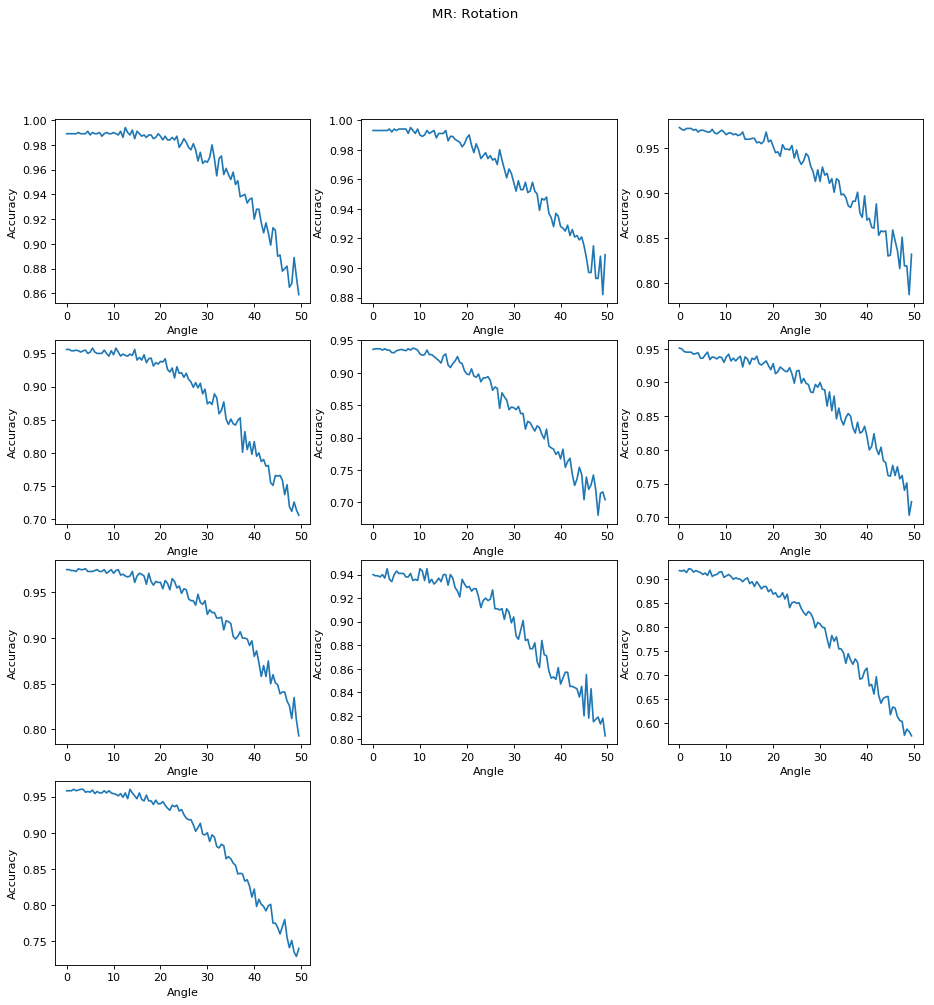

In [13]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(14, 14), dpi=80, facecolor='w', edgecolor='k')

zero = []
for j in range(10):
    zero = []
    for i in range(len(aMatrix)):
        zero.append(aMatrix[i][j][j])
    plt.subplot(4,3,j+1)
    plt.plot(np.arange(0,50,0.5),zero)
    plt.xlabel("Angle")
    plt.ylabel("Accuracy")
plt.suptitle("MR: Rotation")
plt.show()

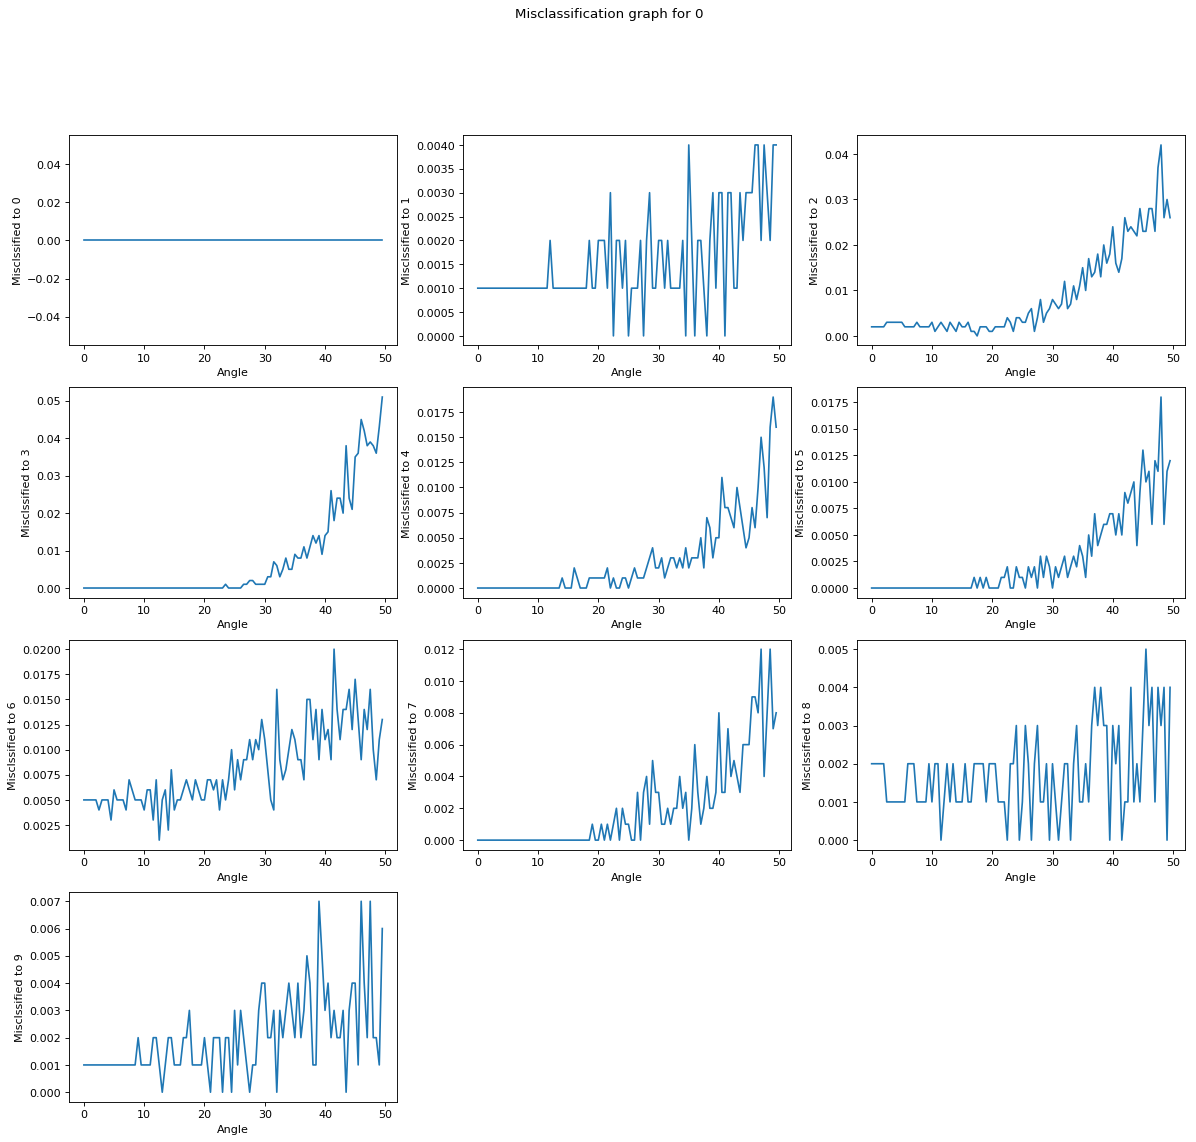

---------------------------------------------------------------------------------------------------------------------


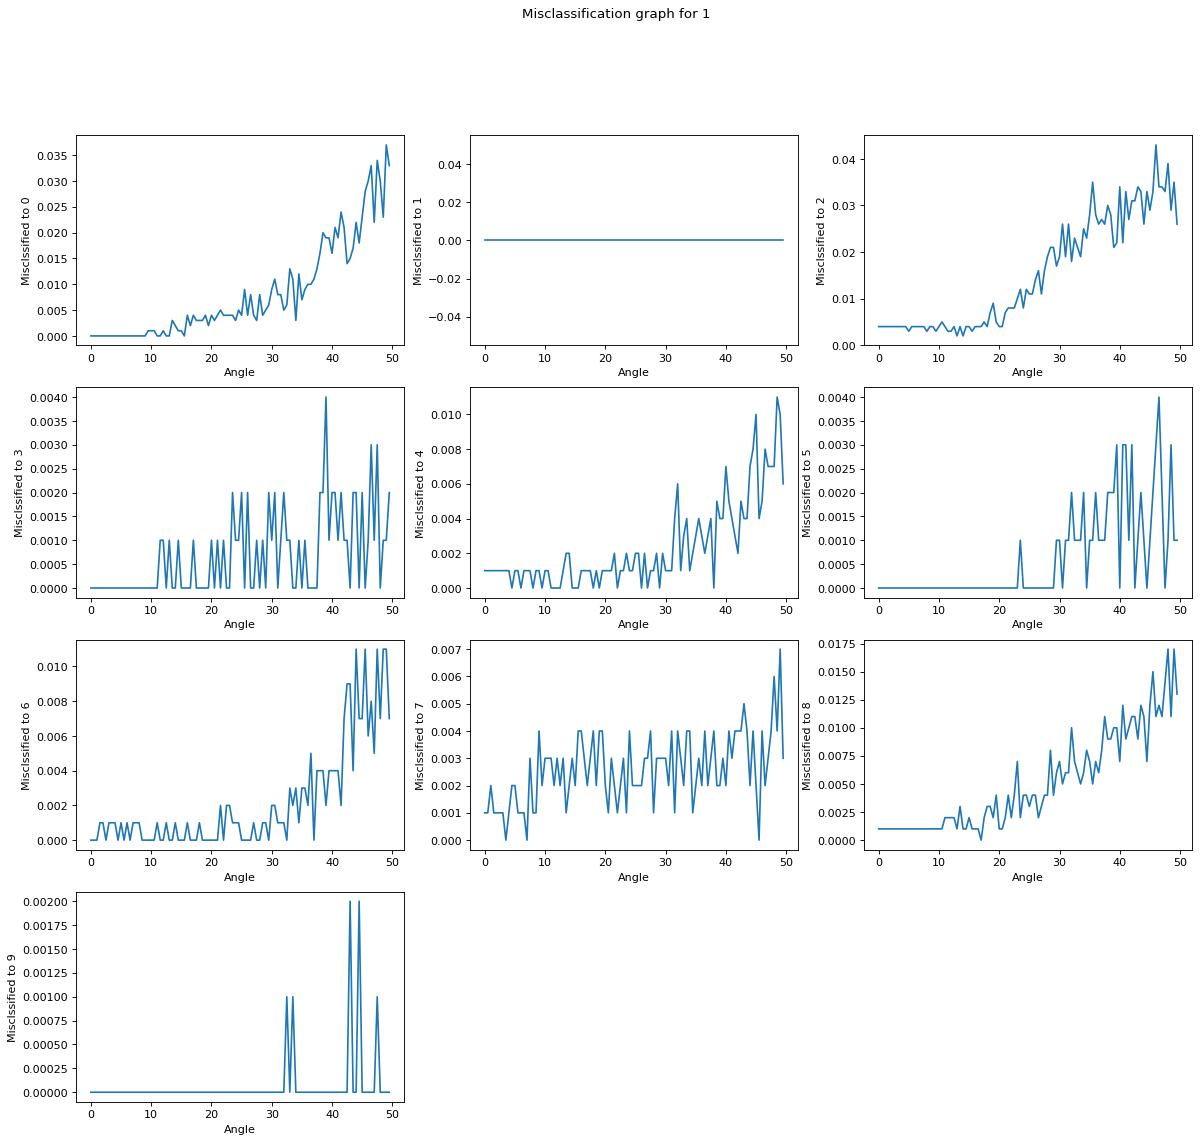

---------------------------------------------------------------------------------------------------------------------


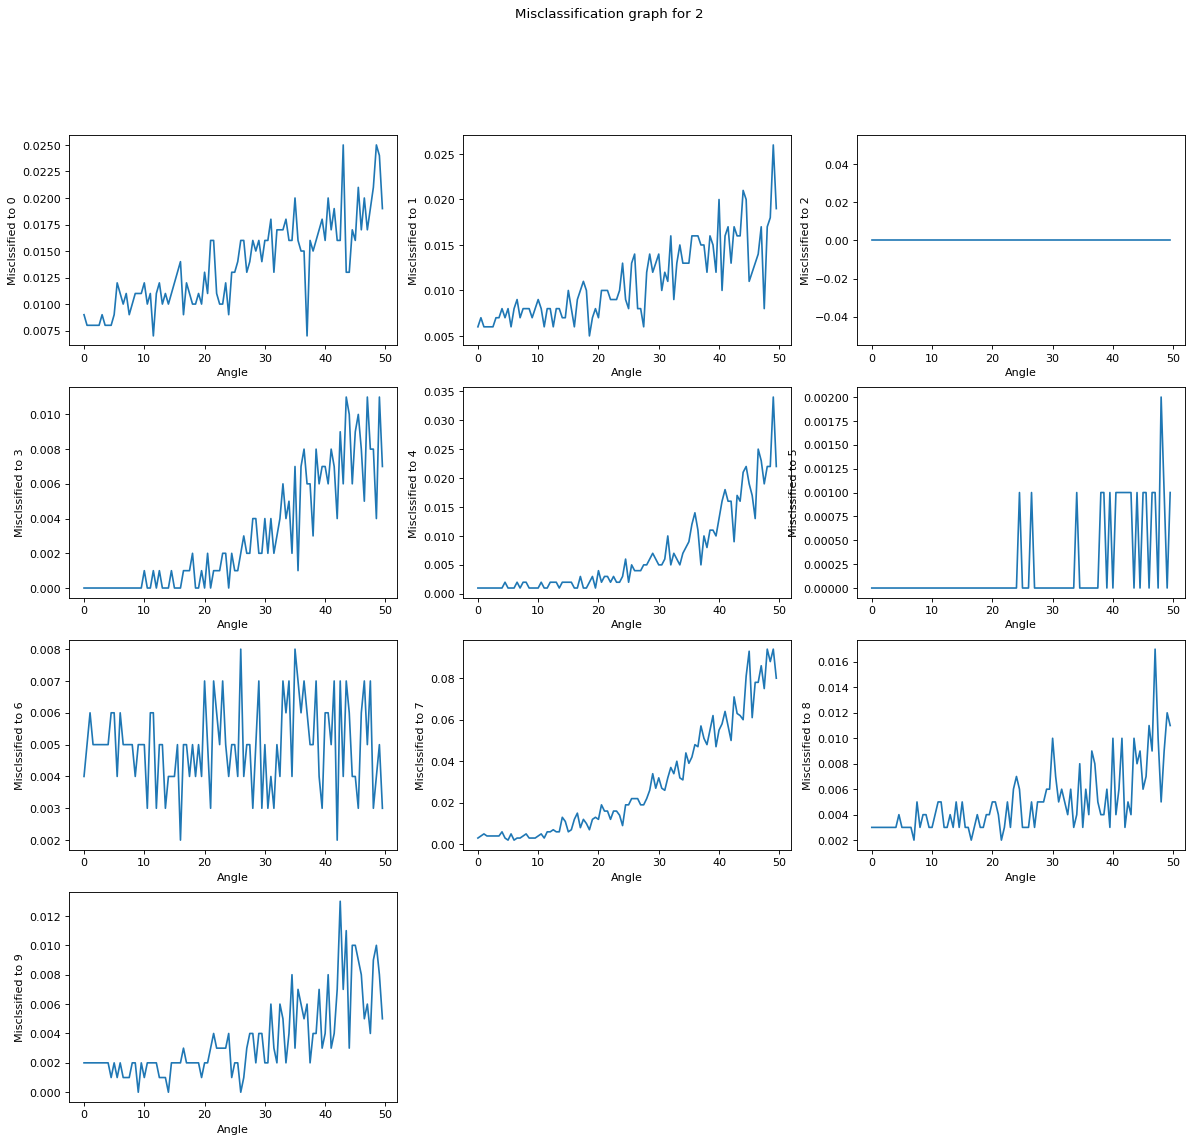

---------------------------------------------------------------------------------------------------------------------


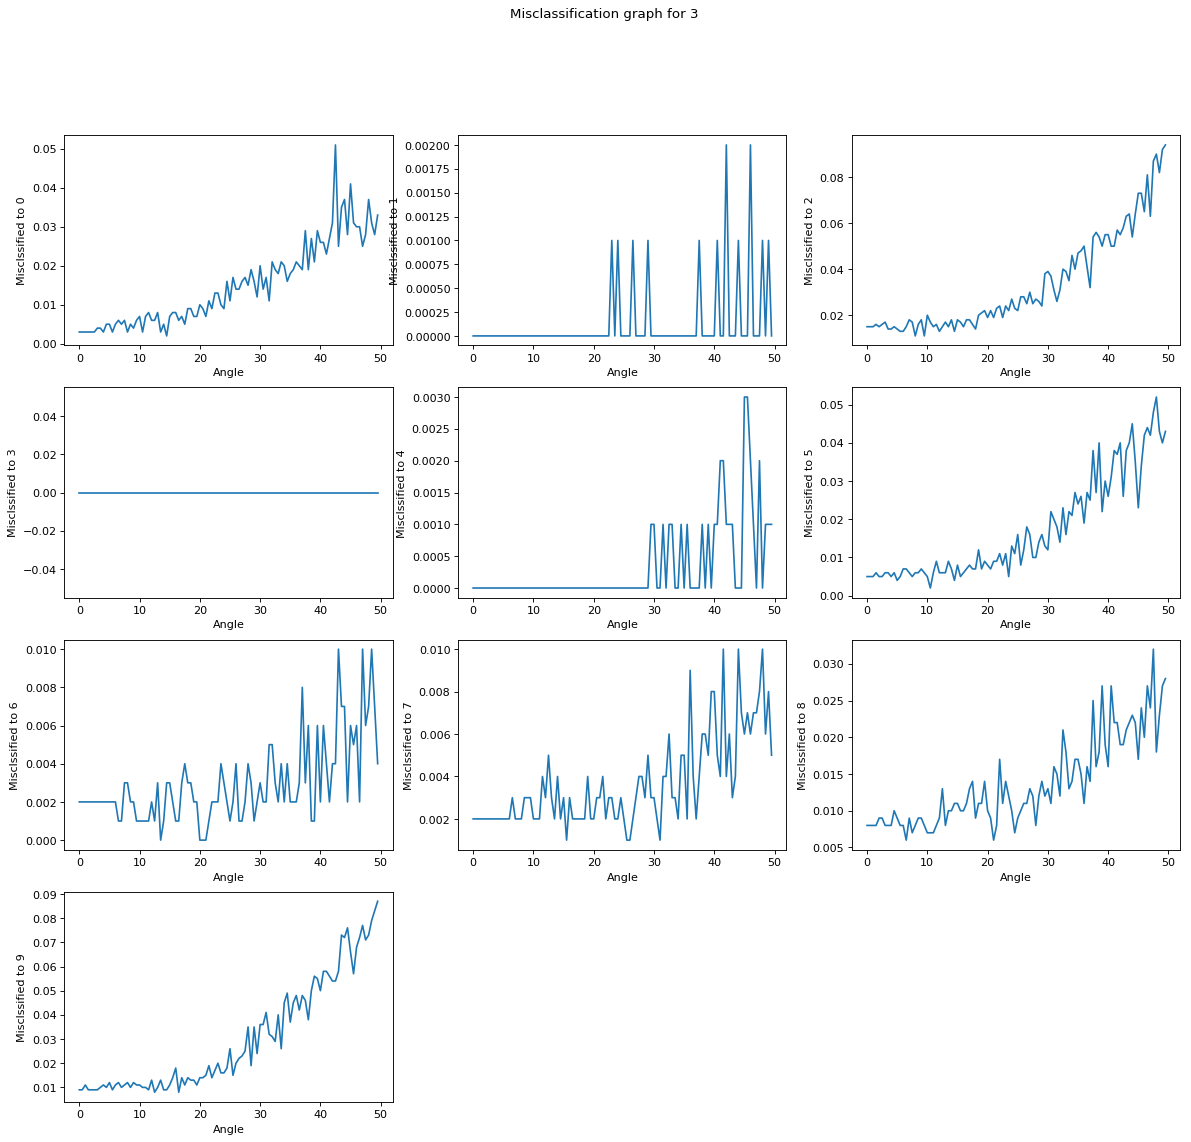

---------------------------------------------------------------------------------------------------------------------


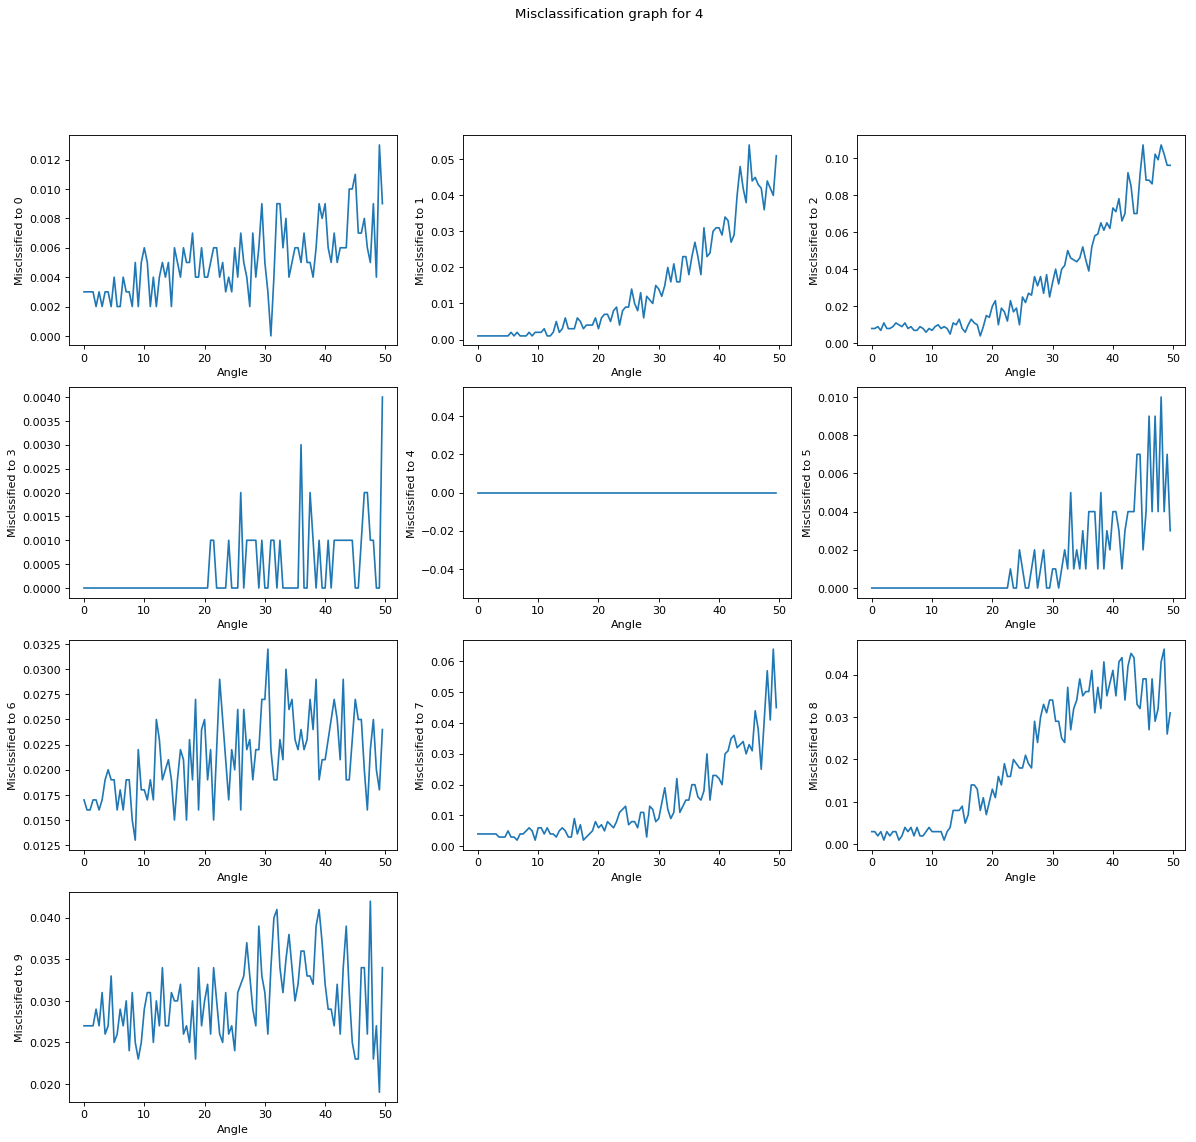

---------------------------------------------------------------------------------------------------------------------


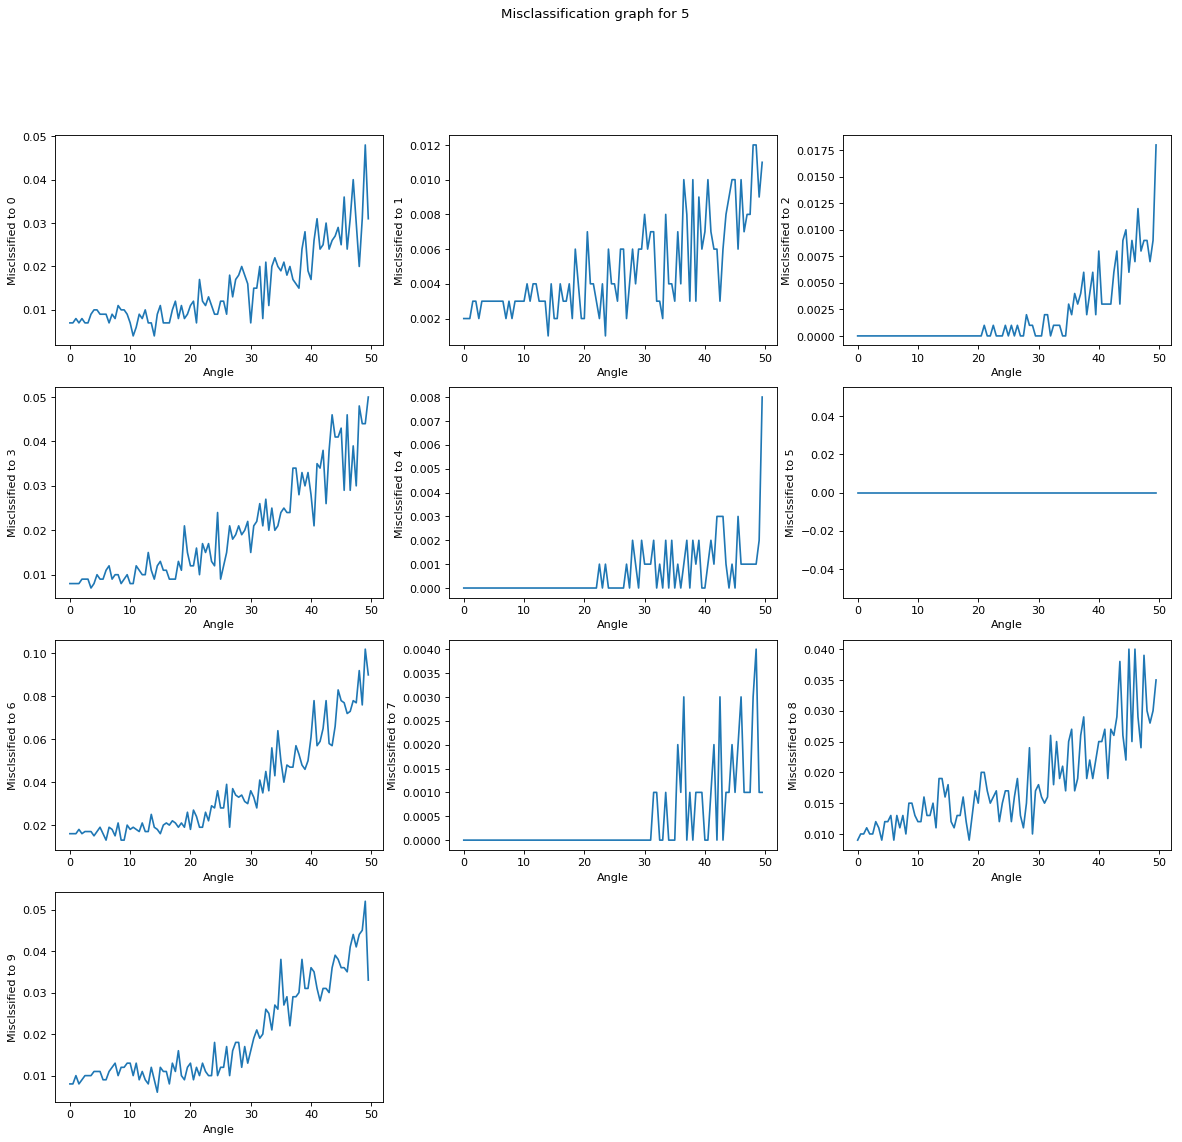

---------------------------------------------------------------------------------------------------------------------


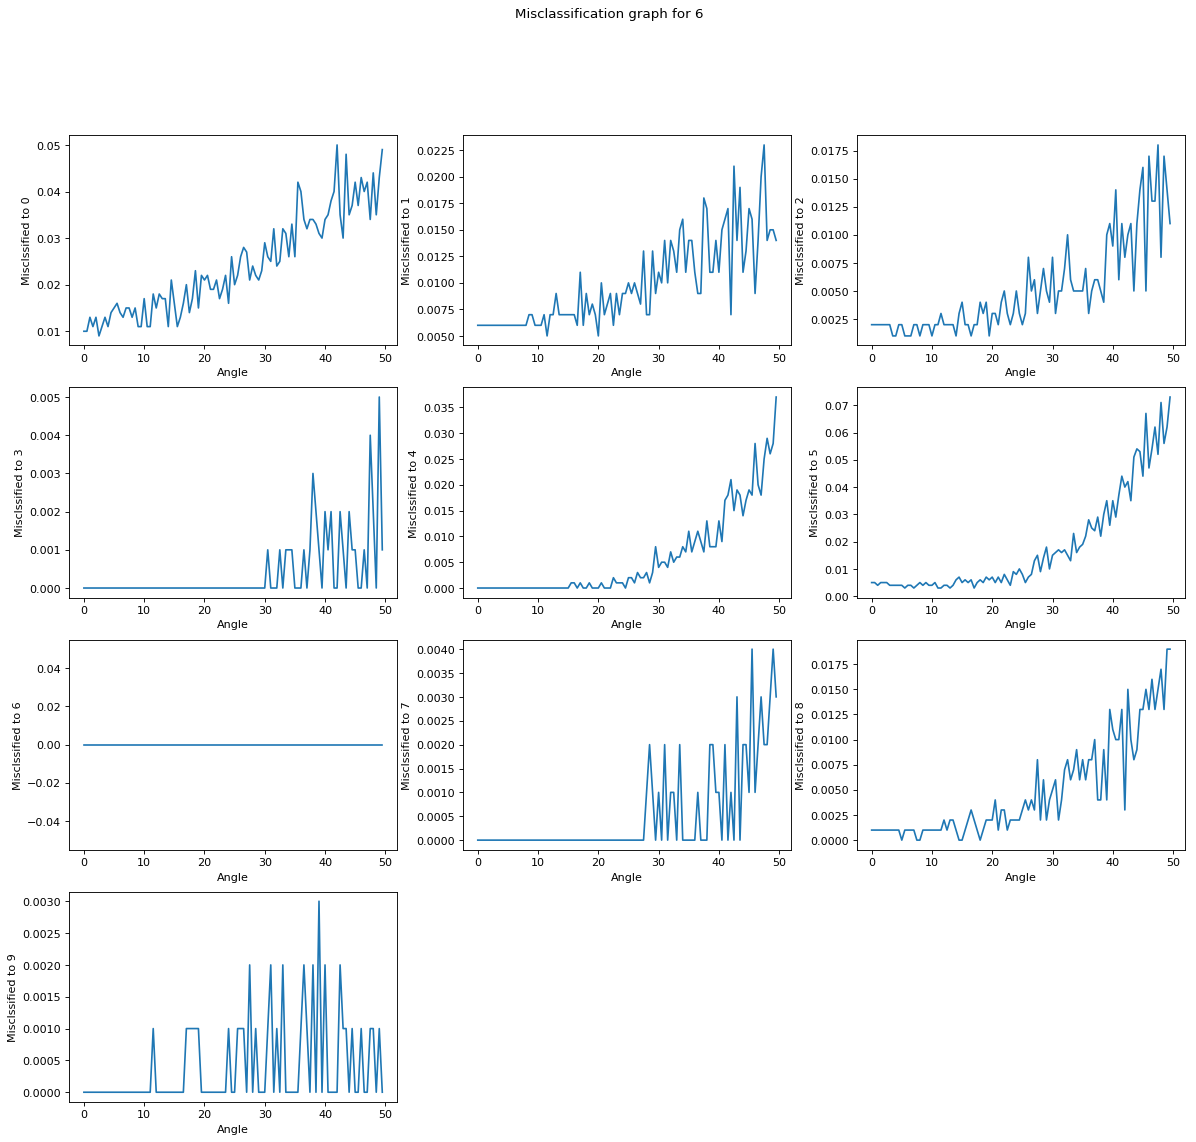

---------------------------------------------------------------------------------------------------------------------


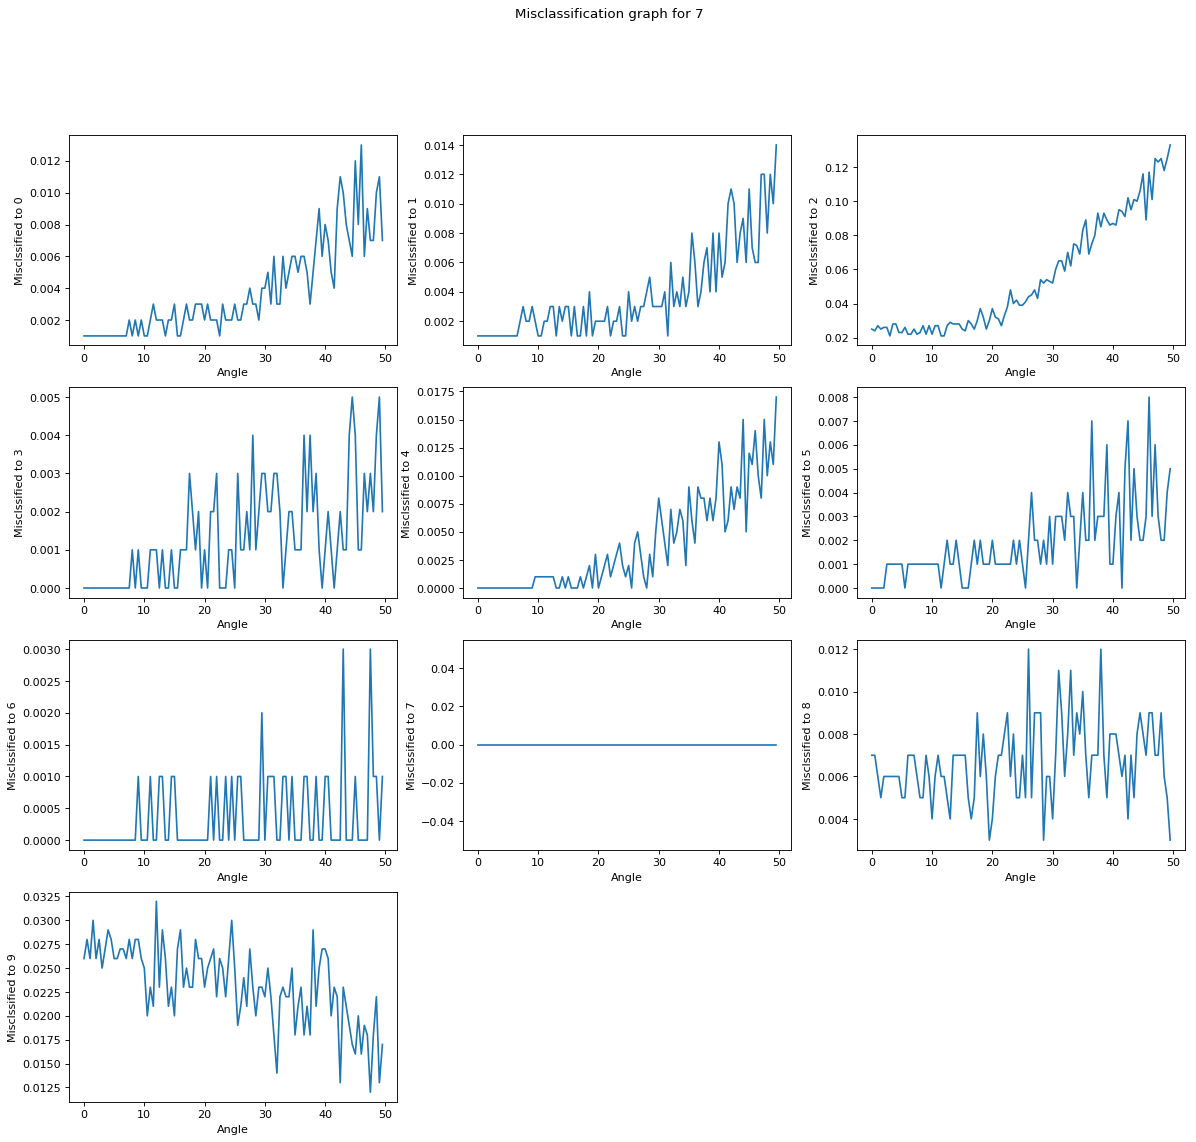

---------------------------------------------------------------------------------------------------------------------


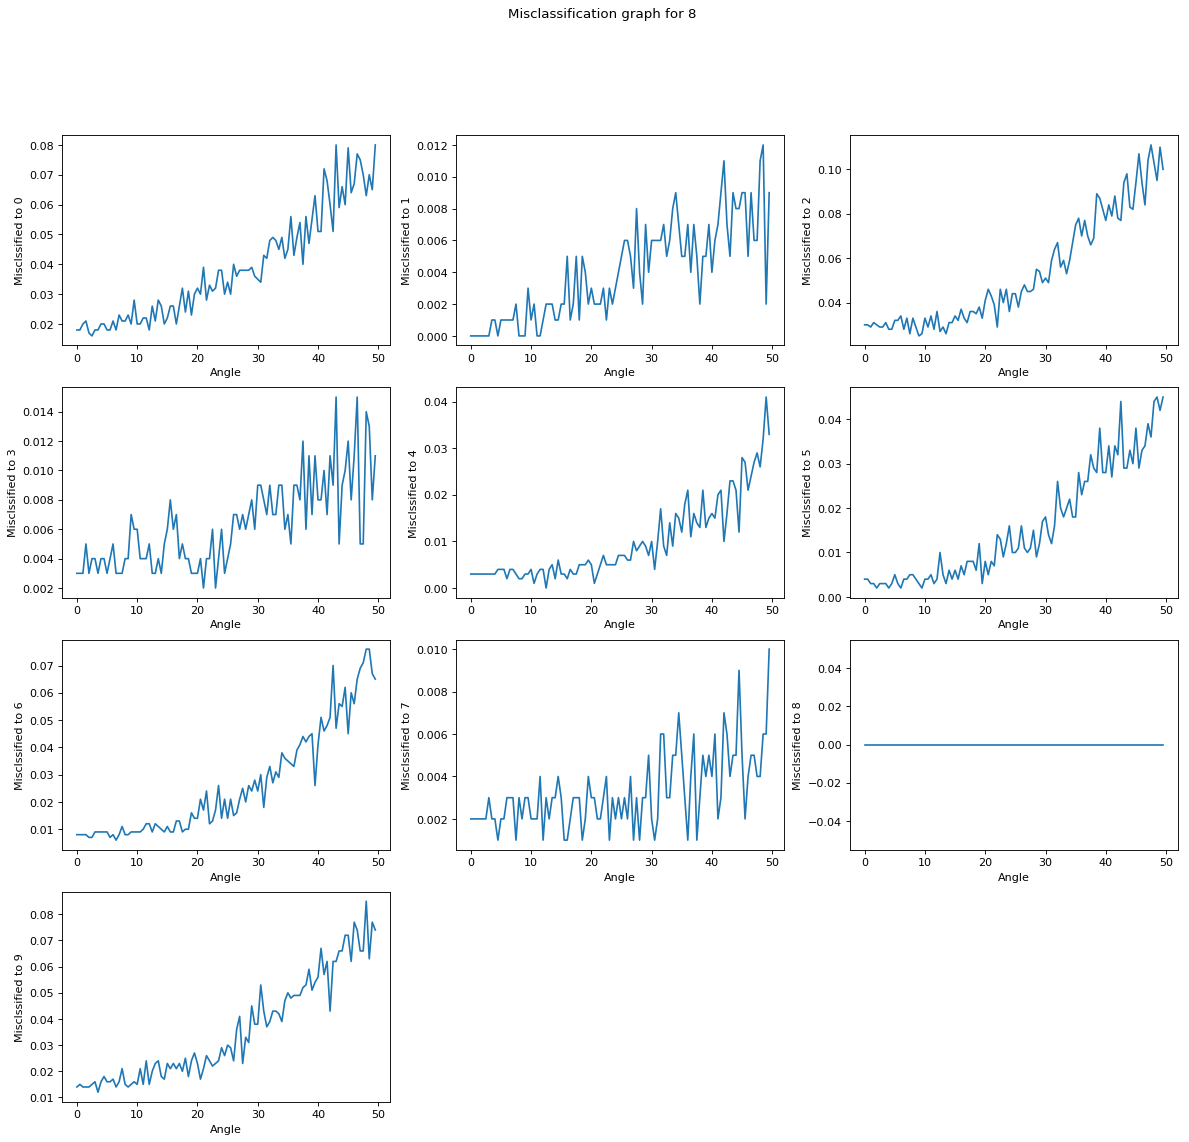

---------------------------------------------------------------------------------------------------------------------


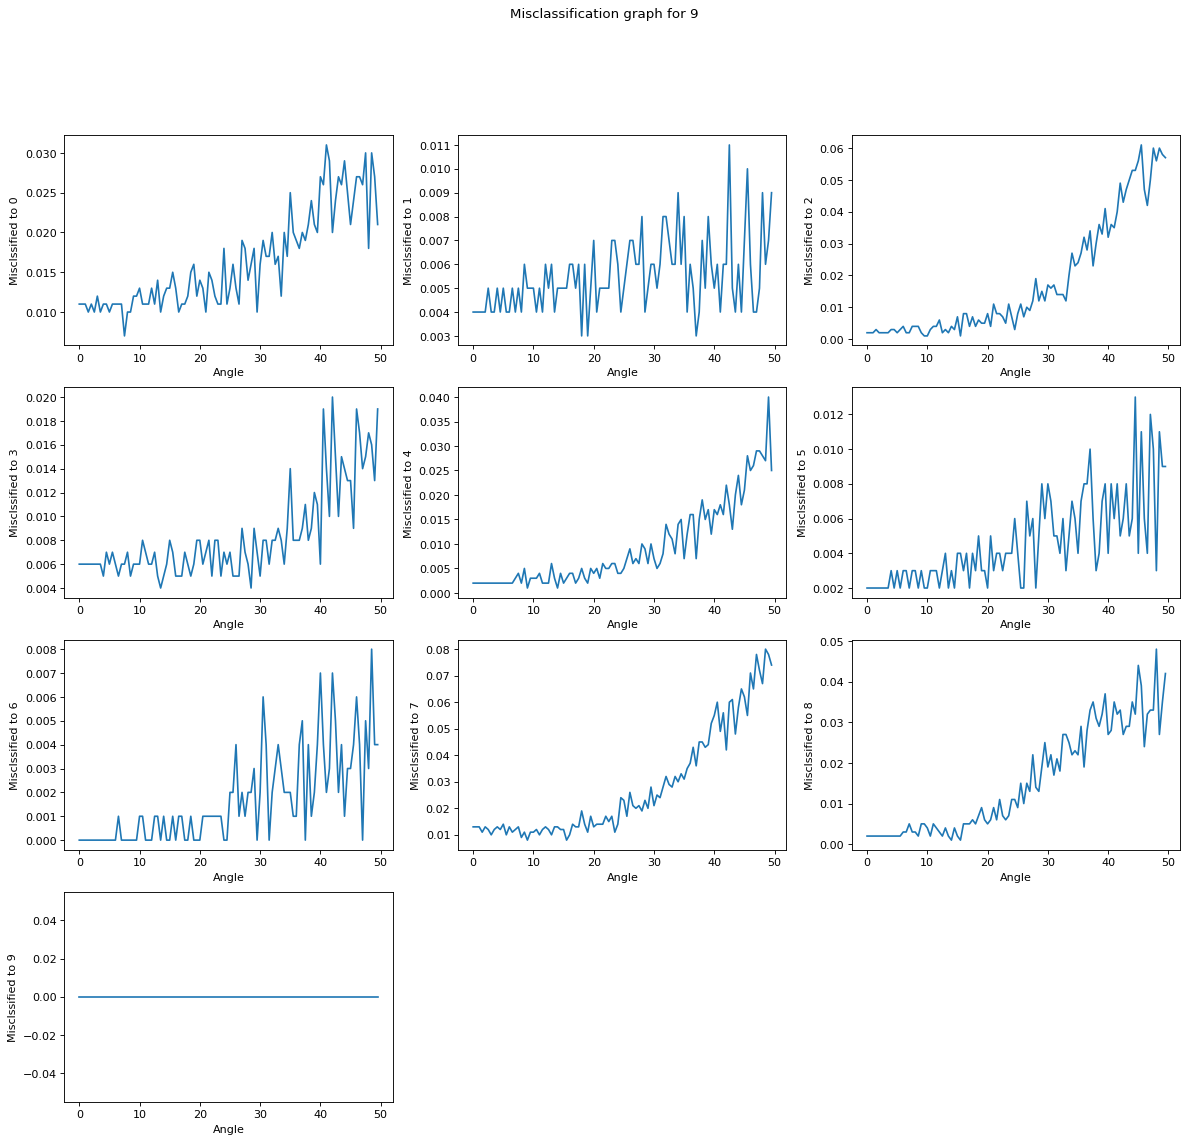

---------------------------------------------------------------------------------------------------------------------


In [14]:
zero = []

for j in range(10):
    figure(num=None, figsize=(18, 16), dpi=80, facecolor='w', edgecolor='k')
    for k in range(0,10):
        zero = []
        if j != k: 
            for i in range(len(aMatrix)):
                zero.append(aMatrix[i][j][k])
        else:
            zero+=100*[0]       
        plt.subplot(4,3,k+1)
        plt.plot(np.arange(0,50,0.5),zero)
        plt.xlabel("Angle")
        plt.ylabel("Misclssified to %s" %str(k))
    plt.suptitle("Misclassification graph for %d" %(j))
    plt.show()
    print("---------------------------------------------------------------------------------------------------------------------")